In [31]:
import numpy as np

import pyvista

try:
    pyvista.start_xvfb()
except OSError:
    pass

from mpi4py import MPI

import ufl
from basix.ufl import element, mixed_element

from dolfinx.mesh import CellType, create_unit_square, exterior_facet_indices

from dolfinx import plot
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    functionspace,
    locate_dofs_topological,
)
from dolfinx.fem.petsc import LinearProblem



In [36]:
msh = create_unit_square(MPI.COMM_WORLD, 96, 96, CellType.triangle)

P1 = element("Lagrange", msh.basix_cell(), degree=1)
E = mixed_element([P1, P1, P1])
V = functionspace(msh, E)

v = ufl.TrialFunction(V)
u = ufl.TrialFunction(V)
U = Function(V)

lamda, u, f = ufl.TrialFunctions(V)
dlamda, du, df = ufl.TestFunctions(V)

alpha = 1.0e-1
zero = Constant(msh, (0.0))

z = Function(functionspace(msh, ("Lagrange", 3)))
z.interpolate(lambda x: x[0]*(1.0 - x[0])*x[1]*(1.0 - x[1]))

a1 = ufl.inner(ufl.grad(u), ufl.grad(dlamda)) * ufl.dx - ufl.inner(f, dlamda) * ufl.dx
a2 = ufl.inner(ufl.grad(lamda), ufl.grad(du)) * ufl.dx - ufl.inner(u, du) * ufl.dx
a3 = ufl.inner(lamda, df) * ufl.dx + alpha * ufl.inner(f, df) * ufl.dx

L1 = zero * dlamda * ufl.dx
L2 = - z * du * ufl.dx
L3 = zero * df * ufl.dx

a = a1 + a2 + a3
L = L1 + L2 + L3

msh.topology.create_connectivity(1, 2)
facets = exterior_facet_indices(msh.topology)

V0, V1, V2 = V.sub(0), V.sub(1), V.sub(2)
dofs0 = locate_dofs_topological(V=V0, entity_dim=1, entities=facets)
bc0 = dirichletbc(value=np.float64(0), dofs=dofs0, V=V0)

dofs1 = locate_dofs_topological(V=V1, entity_dim=1, entities=facets)
bc1 = dirichletbc(value=np.float64(0), dofs=dofs1, V=V1)

bcs = [bc0, bc1]


problem = LinearProblem(a, L, bcs=bcs)
uh = problem.solve()

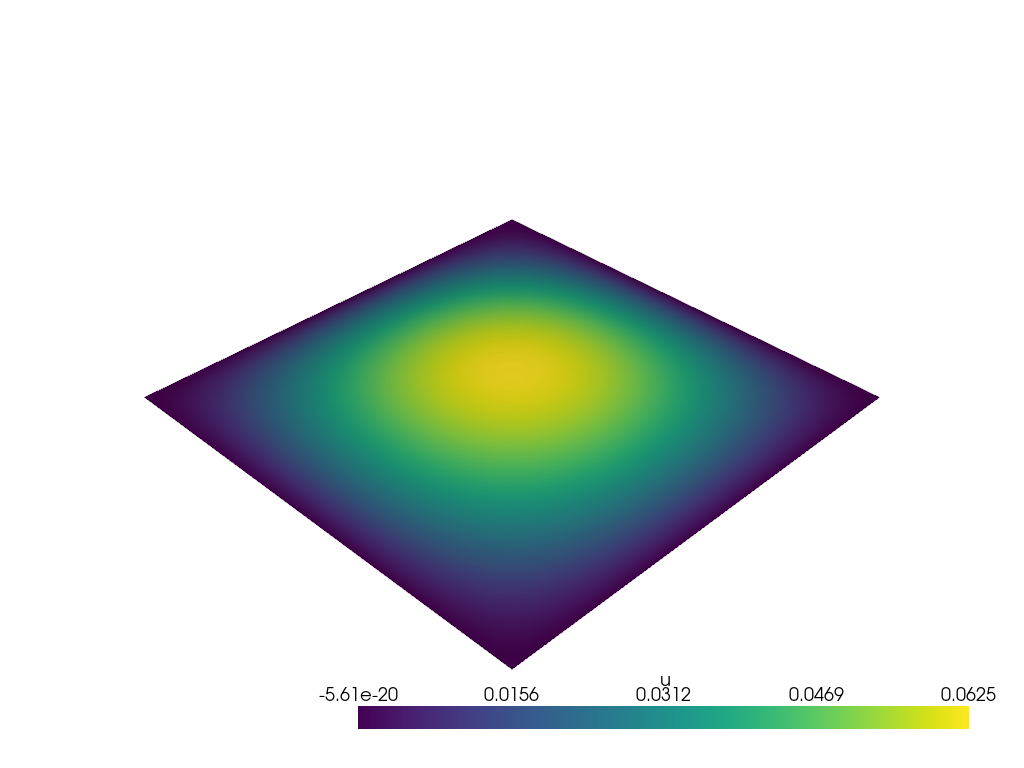

In [37]:
_uh = z

cells, types, x = plot.vtk_mesh(_uh.function_space)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = _uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    plotter.screenshot("uh_poisson.png")
else:
    plotter.show()

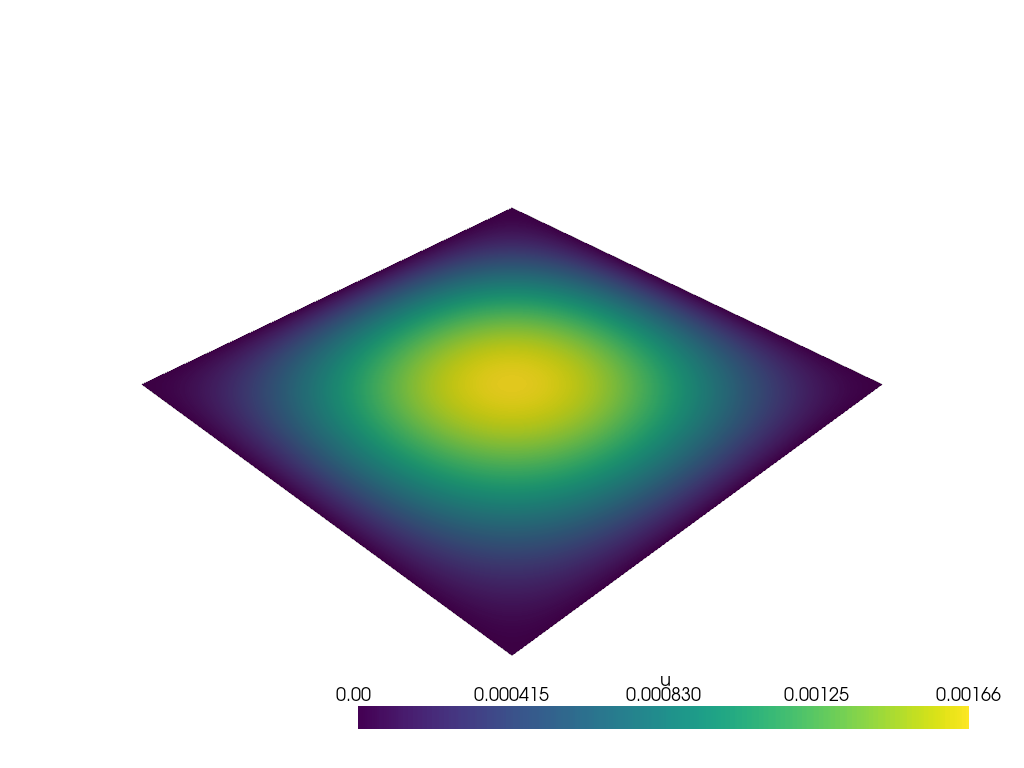

In [38]:
_uh = uh.sub(1).collapse()

cells, types, x = plot.vtk_mesh(_uh.function_space)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = _uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    plotter.screenshot("uh_poisson.png")
else:
    plotter.show()


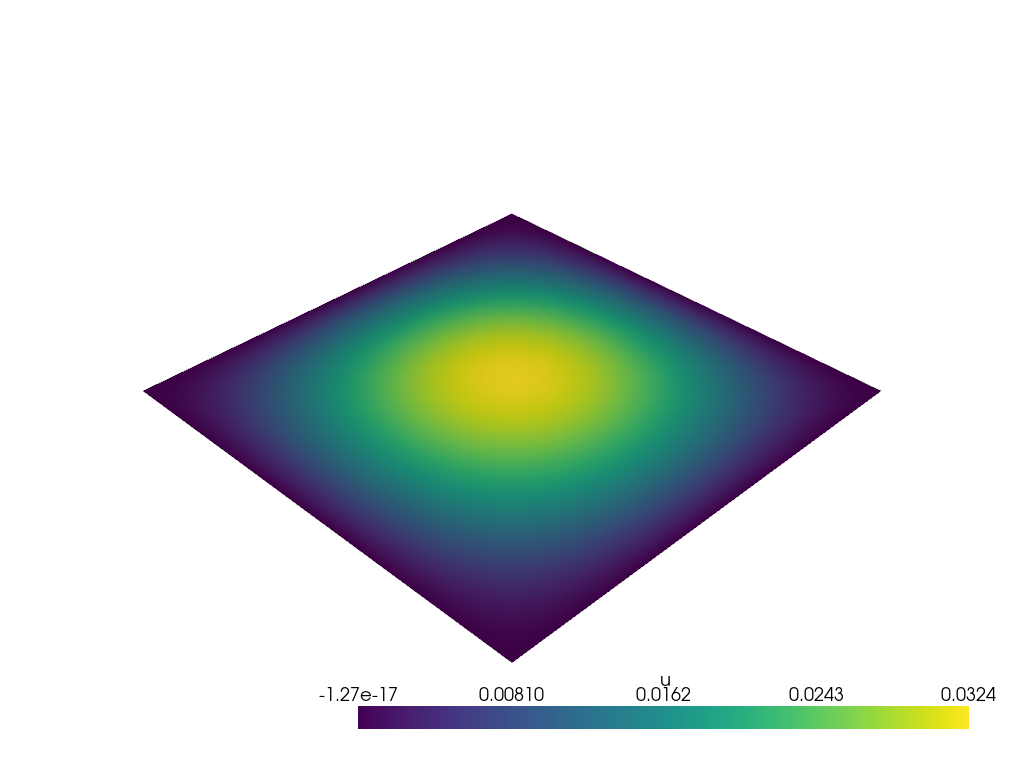

In [39]:
_uh = uh.sub(2).collapse()

cells, types, x = plot.vtk_mesh(_uh.function_space)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = _uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    plotter.screenshot("uh_poisson.png")
else:
    plotter.show()
